# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [1]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 12

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [2]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_full,
    y_full,
    test_size=0.3,
    random_state=GROUP_NUMBER
)


In [3]:
def create_layer(input_size, output_size):

    # Small random weights
    weights = torch.randn(input_size, output_size) * 0.1

    # Bias starts from zero
    bias = torch.zeros(output_size)

    # Tell PyTorch to track gradients
    weights.requires_grad = True
    bias.requires_grad = True

    return weights, bias

W_layer1, b_layer1 = create_layer(2, 16)
W_layer2, b_layer2 = create_layer(16, 16)
W_layer3, b_layer3 = create_layer(16, 16)
W_layer4, b_layer4 = create_layer(16, 1)


In [4]:
def relu_activation(input_tensor):
    return torch.clamp(input_tensor, min=0)

def sigmoid_activation(input_tensor):
    return 1 / (1 + torch.exp(-input_tensor))


In [5]:
def model_forward(input_data):

    layer1_linear = torch.matmul(input_data, W_layer1) + b_layer1
    layer1_output = relu_activation(layer1_linear)

    layer2_linear = torch.matmul(layer1_output, W_layer2) + b_layer2
    layer2_output = relu_activation(layer2_linear)

    layer3_linear = torch.matmul(layer2_output, W_layer3) + b_layer3
    layer3_output = relu_activation(layer3_linear)

    final_linear = torch.matmul(layer3_output, W_layer4) + b_layer4
    prediction = sigmoid_activation(final_linear)

    return prediction


In [6]:
def binary_cross_entropy_loss(predicted, actual):

    small_value = 1e-7
    predicted = torch.clamp(predicted, small_value, 1 - small_value)

    loss_part1 = actual * torch.log(predicted)
    loss_part2 = (1 - actual) * torch.log(1 - predicted)

    loss = -(loss_part1 + loss_part2)
    average_loss = loss.mean()

    return average_loss


In [7]:
def calculate_accuracy(predicted, actual):
    predicted_labels = (predicted >= 0.5).float()
    correct = (predicted_labels == actual).float()
    accuracy = correct.mean()
    return accuracy


In [11]:
learning_rate = 0.01
total_epochs = 200

training_losses = []
validation_losses = []

training_accuracies = []
validation_accuracies = []

for epoch_number in range(total_epochs):

    # Training step
    train_predictions = model_forward(X_train)
    train_loss = binary_cross_entropy_loss(train_predictions, y_train)
    train_accuracy = calculate_accuracy(train_predictions, y_train)

    # Compute gradients
    train_loss.backward()

    # Update weights manually
    with torch.no_grad():
        for W, b in [
            (W_layer1, b_layer1),
            (W_layer2, b_layer2),
            (W_layer3, b_layer3),
            (W_layer4, b_layer4)
        ]:
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

            W.grad.zero_()
            b.grad.zero_()

    # Validatio Step
    validation_predictions = model_forward(X_val)
    val_loss = binary_cross_entropy_loss(validation_predictions, y_val)
    val_accuracy = calculate_accuracy(validation_predictions, y_val)

    training_losses.append(train_loss.item())
    validation_losses.append(val_loss.item())

    training_accuracies.append(train_accuracy.item())
    validation_accuracies.append(val_accuracy.item())

    if epoch_number % 20 == 0:
        print(
            f"Epoch {epoch_number} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f}"
        )


Epoch 0 | Train Loss: 0.6768 | Val Loss: 0.6736
Epoch 20 | Train Loss: 0.6759 | Val Loss: 0.6725
Epoch 40 | Train Loss: 0.6751 | Val Loss: 0.6715
Epoch 60 | Train Loss: 0.6744 | Val Loss: 0.6706
Epoch 80 | Train Loss: 0.6738 | Val Loss: 0.6698
Epoch 100 | Train Loss: 0.6732 | Val Loss: 0.6691
Epoch 120 | Train Loss: 0.6727 | Val Loss: 0.6684
Epoch 140 | Train Loss: 0.6723 | Val Loss: 0.6678
Epoch 160 | Train Loss: 0.6719 | Val Loss: 0.6673
Epoch 180 | Train Loss: 0.6715 | Val Loss: 0.6668


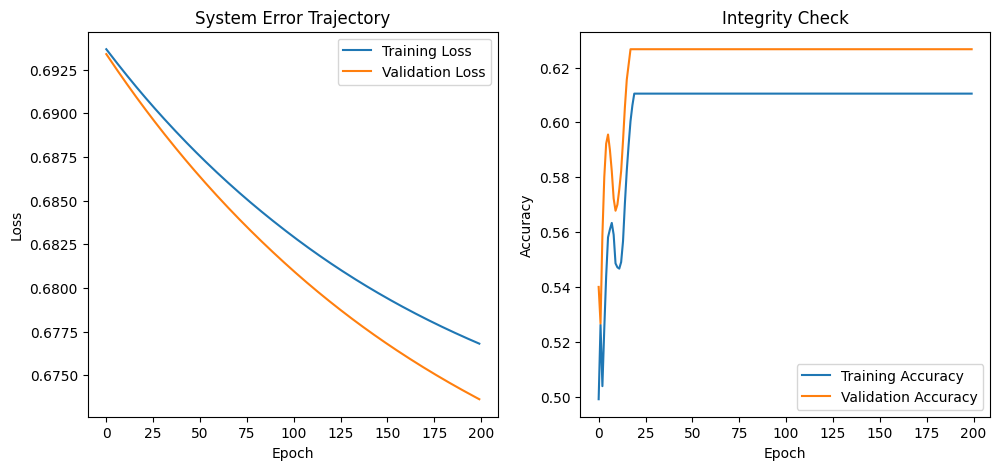

In [9]:
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.title("System Error Trajectory")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,3,2)
plt.plot(training_accuracies, label="Training Accuracy")
plt.plot(validation_accuracies, label="Validation Accuracy")
plt.title("Integrity Check")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()


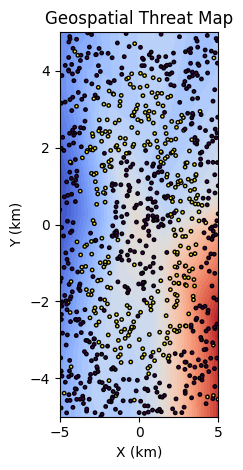

In [10]:
x_values, y_values = torch.meshgrid(
    torch.linspace(-5, 5, 300),
    torch.linspace(-5, 5, 300),
    indexing='ij'
)

grid_points = torch.stack(
    [x_values.flatten(), y_values.flatten()],
    dim=1
)

with torch.no_grad():
    grid_predictions = model_forward(grid_points)
    grid_predictions = grid_predictions.reshape(x_values.shape)

plt.subplot(1,3,3)
plt.contourf(x_values, y_values, grid_predictions, levels=50, cmap="coolwarm")
plt.scatter(
    X_val[:, 0],
    X_val[:, 1],
    c=y_val.squeeze(),
    s=6,
    edgecolors="black"
)
plt.contour(
    x_values,
    y_values,
    grid_predictions,
    levels=[0.5],
    colors="black"
)

plt.title("Geospatial Threat Map")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.tight_layout()
plt.show()
